In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pydrake.all import RigidTransform, RollPitchYaw, RotationMatrix

Camera poses in table frame:
[RigidTransform(
  R=RotationMatrix([
    [-0.008426572055398018, 0.49998224790571183, -0.865994656255191],
    [0.9999644958114239, 0.004213286027699008, -0.007297625466794737],
    [0.0, -0.8660254037844386, -0.49999999999999983],
  ]),
  p=[0.5567144688632728, -0.003735510093671053, 0.29574999999999996],
), RigidTransform(
  R=RotationMatrix([
    [0.7564493864543211, -0.32702611735642795, 0.5664258506633156],
    [-0.6540522347128561, -0.3782246932271605, 0.6551043853465944],
    [0.0, -0.8660254037844387, -0.4999999999999999],
  ]),
  p=[-0.4067672805262673, -0.5122634135249003, 0.29574999999999996],
), RigidTransform(
  R=RotationMatrix([
    [-0.8214529060279898, -0.28513817842327355, 0.49387381220674975],
    [-0.5702763568465472, 0.4107264530139948, -0.7113990846327904],
    [0.0, -0.8660254037844387, -0.4999999999999999],
  ]),
  p=[-0.35091572089593653, 0.4881919030929625, 0.29574999999999996],
)]
Camera poses in world frame:
[RigidTransform(
  R

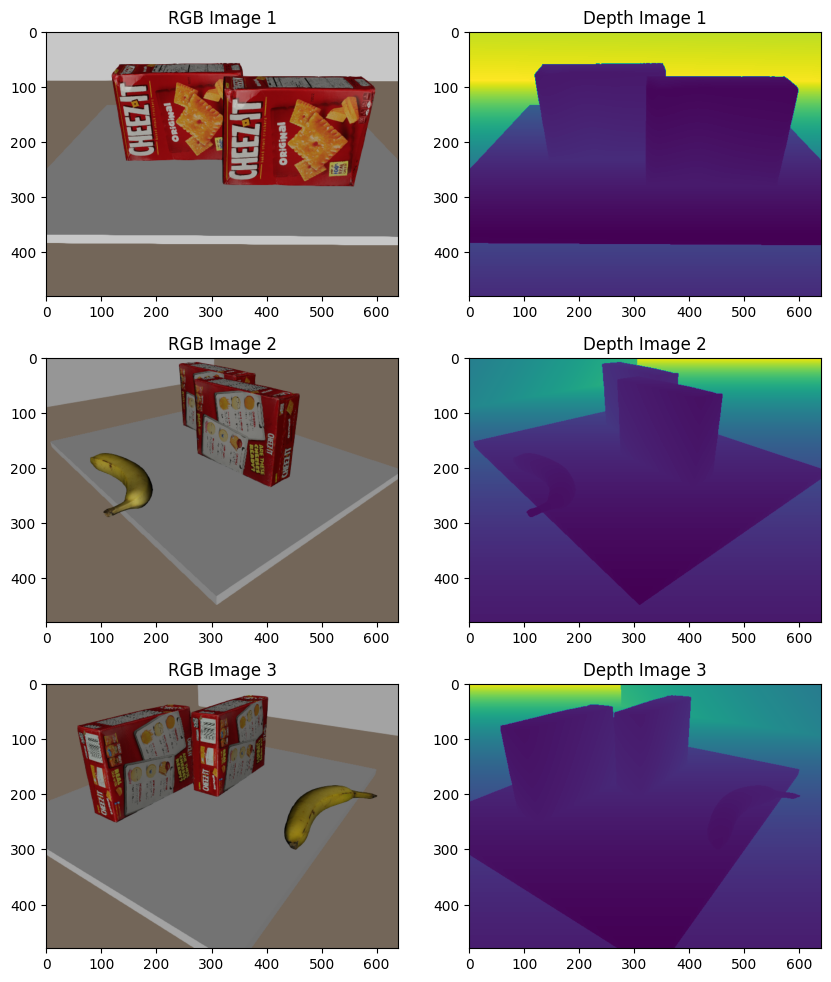

In [3]:
import matplotlib.pyplot as plt
import pickle

# Test loading in camera poses and images:
with open("../images.pkl", "rb") as f:
    rgb_imgs = pickle.load(f)
    depth_imgs = pickle.load(f)
    camera_poses_table_frame = pickle.load(f)
    camera_poses_world_frame = pickle.load(f)
    table_pose_world_frame = pickle.load(f)
    camera_infos = pickle.load(f)

# Print poses and visualize images in same grid as above:
print("Camera poses in table frame:")
print(camera_poses_table_frame)
print("Camera poses in world frame:")
print(camera_poses_world_frame)
print("Table pose in world frame:")
print(table_pose_world_frame)
print("Camera infos:")
print(camera_infos)
fig, axs = plt.subplots(3, 2, figsize=(10, 12))
for camera_idx in range(3):
    axs[camera_idx, 0].imshow(rgb_imgs[camera_idx])
    axs[camera_idx, 0].set_title(f"RGB Image {camera_idx+1}")
    axs[camera_idx, 1].imshow(depth_imgs[camera_idx])
    axs[camera_idx, 1].set_title(f"Depth Image {camera_idx+1}")

In [4]:
categories = ["cracker_box", "banana"]

In [5]:
idx = 0

In [6]:
# check camera info
camera_info = camera_infos[idx]
print("intrinsics", camera_info.intrinsic_matrix())
print("focal length", camera_info.focal_x(), camera_info.focal_y())
print("field of view", camera_info.fov_x(), camera_info.fov_y())

intrinsics [[579.41125497   0.         319.5       ]
 [  0.         579.41125497 239.5       ]
 [  0.           0.           1.        ]]
focal length 579.4112549695427 579.4112549695427
field of view 1.009191289973297 0.7853981633974485


In [7]:
camera_pose = camera_poses_world_frame[idx]
table_top_pose = table_pose_world_frame

print("camera_pose", camera_pose)
print("table_top_pose", table_top_pose)

camera_pose RigidTransform(
  R=RotationMatrix([
    [-0.008426572055398018, 0.49998224790571183, -0.865994656255191],
    [0.9999644958114239, 0.004213286027699008, -0.007297625466794737],
    [0.0, -0.8660254037844386, -0.49999999999999983],
  ]),
  p=[0.5567144688632728, -0.003735510093671053, 0.495],
)
table_top_pose RigidTransform(
  R=RotationMatrix([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
  ]),
  p=[0.0, 0.0, 0.19925],
)


In [8]:
from typing import NamedTuple


class CameraImage(NamedTuple):
    camera_pose: RigidTransform
    intrinsics: np.ndarray # 3 x 3
    color_image: np.ndarray # W x H x 3
    depth_image: np.ndarray # W x H

camera_image = CameraImage(
    camera_pose=camera_pose,
    intrinsics=camera_info.intrinsic_matrix(),
    color_image=rgb_imgs[idx][:, :, :3],
    depth_image=depth_imgs[idx][:, :, 0],
)

In [9]:
import sponana.perception.bayes3d.bayes3d_interface as b3d

In [10]:
import jax.numpy as jnp

In [11]:
rigid_transform = camera_pose
RigidTransform(jnp.array(rigid_transform.GetAsMatrix4()))

RigidTransform(
  R=RotationMatrix([
    [-0.008426572196185589, 0.49998223781585693, -0.8659946322441101],
    [0.9999644756317139, 0.004213286098092794, -0.007297625299543142],
    [0.0, -0.8660253882408142, -0.5],
  ]),
  p=[0.5567144751548767, -0.003735510166734457, 0.4950000047683716],
)

In [12]:
def external_pose_to_b3d_pose(rigid_transform):
    return jnp.array(rigid_transform.GetAsMatrix4())

def b3d_pose_to_external_pose(b3d_pose):
    return RigidTransform(b3d_pose)

## Belief init

In [13]:
(known_poses, possible_poses) = b3d.b3d_init(
    camera_image,
    categories,
    'banana',
    3,
    (table_top_pose, 0.49, 0.63, 0.015),
    scaling_factor=0.2,
    external_pose_to_b3d_pose=external_pose_to_b3d_pose,
    b3d_pose_to_external_pose=b3d_pose_to_external_pose,
)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 96, 1024)
Centering mesh with translation [0.   0.   0.09]
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Fitting object 0...
Fitting object 1...
Fitting object 2...


## Consider probable effects of different looking positions

In [19]:
is_visible = b3d.b3d_is_visible(
    known_poses, possible_poses, camera_poses_world_frame[1],
    'banana',
    external_pose_to_b3d_pose=external_pose_to_b3d_pose,
    b3d_pose_to_external_pose=b3d_pose_to_external_pose,
)

In [24]:
count_visible = jnp.count_nonzero(is_visible)
count_invisible = jnp.count_nonzero(~is_visible)
print(f"Visible count: {count_visible}, Invisible count: {count_invisible}")
print(f"Visible fraction: {count_visible / (count_visible + count_invisible)}")

Visible count: 754, Invisible count: 10
Visible fraction: 0.9869109988212585


## Belief update

In [14]:
idx2 = 1
camera_image2 = CameraImage(
    camera_pose=camera_poses_world_frame[idx2],
    intrinsics=camera_infos[idx2].intrinsic_matrix(),
    color_image=rgb_imgs[idx2][:, :, :3],
    depth_image=depth_imgs[idx2][:, :, 0],
)

In [18]:
(updated_known, updated_possible) = b3d.b3d_update(
    known_poses, possible_poses, camera_image2, table_top_pose, 'banana',
    external_pose_to_b3d_pose=external_pose_to_b3d_pose,
    b3d_pose_to_external_pose=b3d_pose_to_external_pose,
    scaling_factor=0.2
)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 96, 1024)
Centering mesh with translation [0.   0.   0.09]
Target object is visible.
